In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern, \
    RationalQuadratic, ExpSineSquared, DotProduct, Sum, Product, Exponentiation
from sklearn.model_selection import KFold

In [2]:
FAST_DEBUG = False
FONTSIZE = 14

In [3]:
vox_df = pd.read_csv('dataset/microstructure_stats.csv')
len(vox_df), vox_df.columns

(798,
 Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        ...
        '19673', '19674', '19675', '19676', '19677', '19678', '19679', '19680',
        '19681', '19682'],
       dtype='object', length=19683))

# Normalize voxel data

In [35]:
vox_std_scaler = StandardScaler()
vox_scaled = vox_std_scaler.fit_transform(vox_df)
vox_scaled.shape

(798, 19683)

# PCA - Find optimal number of components

In [5]:
if not FAST_DEBUG:
    n_list = []
    ev_list = []
    for n in tqdm(range(1, 50)):
        pca = PCA(n_components=n)
        pca.fit_transform(vox_scaled)
        n_list.append(n)
        ev_list.append(sum(pca.explained_variance_ratio_))

100%|██████████| 49/49 [02:21<00:00,  2.88s/it]


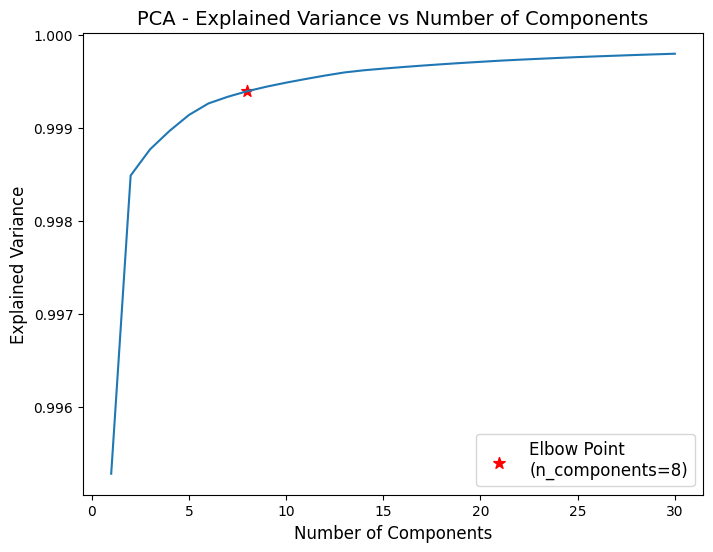

In [6]:
if not FAST_DEBUG:
    MAX_N = 30
    i = 7
    plt.figure(figsize=(8, 6))
    plt.plot(n_list[:MAX_N], ev_list[:MAX_N])
    plt.scatter(n_list[i], ev_list[i], c='r', marker='*', s=75, label=f'Elbow Point\n(n_components={n_list[i]})')
    plt.legend(fontsize=FONTSIZE-2)
    plt.title('PCA - Explained Variance vs Number of Components', fontsize=FONTSIZE)
    plt.xlabel('Number of Components', fontsize=FONTSIZE-2)
    plt.ylabel('Explained Variance', fontsize=FONTSIZE-2)

# Transform voxel data using PCA with 8 components

In [7]:
pca = PCA(n_components=8)
vox_pca = pca.fit_transform(vox_scaled)

# Load in training/testing data and normalize

In [8]:
train_df = pd.read_csv('dataset/training_data.csv')
test_df = pd.read_csv('dataset/testing_data.csv')
print(f"train: {len(train_df)}, test: {len(test_df)}")
print(f"train: {train_df.columns}\ntest: {test_df.columns}")

train: 1000, test: 250
train: Index(['microstructure ID', 'strength contrast', 'g', 'chi1', 'chi2'], dtype='object')
test: Index(['microstructure ID', 'strength contrast'], dtype='object')


In [9]:
vox_pca_train = vox_pca[train_df['microstructure ID'].values]
vox_pca_test = vox_pca[test_df['microstructure ID'].values]

In [10]:
sc_train = train_df[['strength contrast']]
sc_test = test_df[['strength contrast']]

In [11]:
X_train = np.concatenate([vox_pca_train, sc_train], axis=1)
X_test = np.concatenate([vox_pca_test, sc_test], axis=1)
X_train.shape, X_test.shape

((1000, 9), (250, 9))

In [12]:
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [13]:
y_scaler = StandardScaler()
y_train = train_df[['g', 'chi1', 'chi2']]
y_train_scaled = y_scaler.fit_transform(y_train)

# Hyperparameter Tunning using Grid Search

In [18]:
if FAST_DEBUG:
    K = 2
else:
    K = 5

def run_kernels(kernels):
    metrics = {}

    for kernel_str, kernel in kernels.items():
        print(f"Running kernel: {kernel_str}")

        mse_list = []
        mae_list = []

        kf = KFold(n_splits=K)
        for train_index, val_index in tqdm(kf.split(X_train_scaled), total=K):
            kf_X_train_scaled = X_train_scaled[train_index]
            kf_X_val_scaled = X_train_scaled[val_index]
            kf_y_train_scaled = y_train_scaled[train_index]
            kf_y_val_scaled = y_train_scaled[val_index]

            gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=0)
            gaussian_process.fit(kf_X_train_scaled, kf_y_train_scaled)

            val_mean_pred_scaled, val_std_pred_scaled = gaussian_process.predict(
                kf_X_val_scaled, return_std=True)
            
            val_mean_pred = y_scaler.inverse_transform(val_mean_pred_scaled)
            val_std_pred = y_scaler.inverse_transform(val_std_pred_scaled)

            kf_y_val_star = train_df[['g', 'chi1', 'chi2']].values[val_index]
            kf_y_val = y_scaler.inverse_transform(kf_y_val_scaled)
            # sanity check: kf_y_val_star == kf_y_val
            assert(np.allclose(kf_y_val_star, kf_y_val))
            mse = np.mean((val_mean_pred - kf_y_val)**2, axis=0)
            mae = np.mean(np.abs(val_mean_pred - kf_y_val), axis=0)
            mse_list.append(mse)
            mae_list.append(mae)
        mse_mean = np.mean(mse_list, axis=0)
        mse_std = np.std(mse_list, axis=0)
        mae_mean = np.mean(mae_list, axis=0)
        mae_std = np.std(mae_list, axis=0)
        metrics[kernel_str] = {
            'mse_mean': mse_mean,
            'mse_std': mse_std,
            'mae_mean': mae_mean,
            'mae_std': mae_std,
        }
    return metrics

In [19]:
def plot_kernel_performance(metrics, title=None, confidence_interval=False):
    # TODO - fix unit labels overlapping

    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel('Kernel', fontsize=FONTSIZE-2)
    # rotate x-axis labels 45 degrees
    ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right')
    ax1.set_ylabel('g', fontsize=FONTSIZE-2)
    kernels = list(metrics.keys())
    g = np.array([metrics[k]['mse_mean'][0] for k in metrics.keys()])
    g_std = np.array([metrics[k]['mse_std'][0] for k in metrics.keys()])
    ax1.plot(kernels, g, label='g (MSE)', marker='o', color='r', linestyle='--')
    if confidence_interval:
        ax1.fill_between(kernels, g - g_std, g + g_std, alpha=0.2, color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_ylabel('g', fontsize=FONTSIZE-2, color='r')
    ax1.legend(loc='upper left', fontsize=FONTSIZE-4)

    ax2 = ax1.twinx()
    chi1 = np.array([metrics[k]['mse_mean'][1] for k in metrics.keys()])
    chi1_std = np.array([metrics[k]['mse_std'][1] for k in metrics.keys()])
    ax2.plot(kernels, chi1, label='chi1 (MSE)', marker='o', color='g', linestyle='-.')
    if confidence_interval:
        ax2.fill_between(kernels, chi1 - chi1_std, chi1 + chi1_std, alpha=0.2, color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.set_ylabel('chi1', fontsize=FONTSIZE-2, color='g')
    ax2.legend(loc='center right', fontsize=FONTSIZE-4)

    ax3 = ax1.twinx()
    chi2 = np.array([metrics[k]['mse_mean'][2] for k in metrics.keys()])
    chi2_std = np.array([metrics[k]['mse_std'][2] for k in metrics.keys()])
    ax3.plot(kernels, chi2, label='chi2 (MSE)', marker='o', color='b', linestyle=':')
    if confidence_interval:
        ax3.fill_between(kernels, chi2 - chi2_std, chi2 + chi2_std, alpha=0.2, color='b')
    ax3.tick_params(axis='y', labelcolor='b')
    ax3.set_ylabel('chi2', fontsize=FONTSIZE-2, color='b')
    ax3.legend(loc='lower right', fontsize=FONTSIZE-4)
    # move axis and unit label position up a bit
    ax3.spines['right'].set_position(('axes', 1.15))
    # ax3.get_yaxis().get_offset_text().set_visible(False)
    ax3.get_yaxis().get_offset_text().set_position((1.3, 0))

    if title is None:
        title = 'GPR - MSE vs Kernel'
    ax3.set_title(title, fontsize=FONTSIZE)

    fig.tight_layout()

In [20]:
def get_performance_table(metrics):
    data = {'Kernel': [], 'g (MSE)': [], 'chi1 (MSE)': [], 'chi2 (MSE)': []}
    for kernel, metric in metrics.items():
        data['Kernel'].append(kernel)
        for i, key in enumerate(['g', 'chi1', 'chi2']):
            data[f'{key} (MSE)'].append(f"{metric['mse_mean'][i]:.3f} ± {metric['mse_std'][i]:.3f}")
    return pd.DataFrame(data)

Running kernel: RBF_1e-2


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Running kernel: RBF_1e-1


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Running kernel: RBF_1e0


100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Running kernel: RBF_1e1


100%|██████████| 5/5 [00:21<00:00,  4.38s/it]


Running kernel: RBF_1e2


100%|██████████| 5/5 [00:22<00:00,  4.49s/it]
/tmp/ipykernel_79435/2111778922.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right')


,Kernel,g (MSE),chi1 (MSE),chi2 (MSE)
0,RBF_1e-2,2.306 ± 0.292,0.255 ± 0.017,0.052 ± 0.007
1,RBF_1e-1,2.306 ± 0.292,0.255 ± 0.017,0.052 ± 0.007
2,RBF_1e0,2.306 ± 0.292,0.255 ± 0.017,0.052 ± 0.007
3,RBF_1e1,2.306 ± 0.292,0.255 ± 0.017,0.052 ± 0.007
4,RBF_1e2,2.306 ± 0.292,0.255 ± 0.017,0.052 ± 0.007


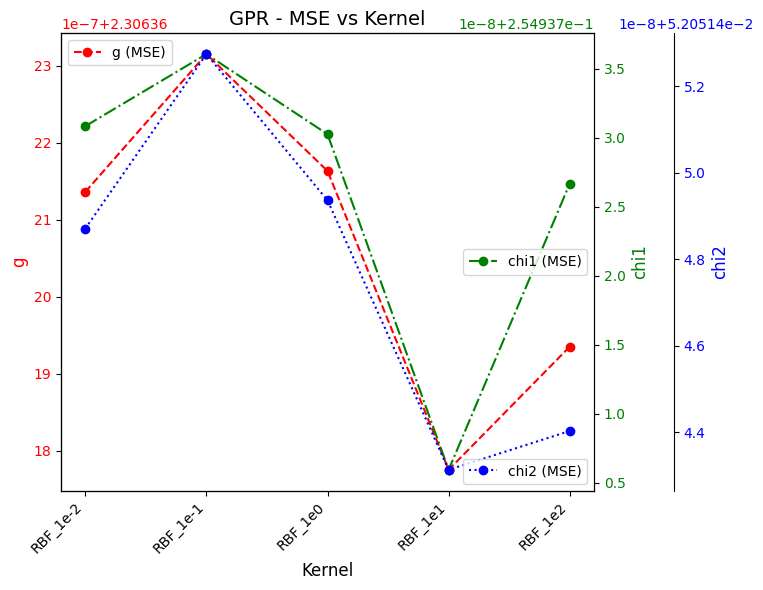

In [21]:
rbf_kernels = {
    'RBF_1e-2': 1 * RBF(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2)),
    'RBF_1e-1': 1 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e2)),
    'RBF_1e0': 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    'RBF_1e1': 1 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e2)),
    'RBF_1e2': 1 * RBF(length_scale=1e2, length_scale_bounds=(1e-2, 1e2)),
}
rbf_metrics = run_kernels(rbf_kernels)
plot_kernel_performance(rbf_metrics, confidence_interval=False)
get_performance_table(rbf_metrics)
# conclusion: length scale doesn't make a difference

Running kernel: Matern_ls1e-2_nu0.1


100%|██████████| 5/5 [01:08<00:00, 13.62s/it]


Running kernel: Matern_ls1e-2_nu0.25


100%|██████████| 5/5 [01:32<00:00, 18.48s/it]


Running kernel: Matern_ls1e-2_nu0.5


100%|██████████| 5/5 [00:19<00:00,  3.97s/it]


Running kernel: Matern_ls1e-2_nu0.75


100%|██████████| 5/5 [01:37<00:00, 19.54s/it]


Running kernel: Matern_ls1e-2_nu1


  0%|          | 0/5 [00:00<?, ?it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|██████████| 5/5 [01:44<00:00, 20.86s/it]


Running kernel: Matern_ls1e-2_nu1.5


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Running kernel: Matern_ls1e-2_nu2


  0%|          | 0/5 [00:00<?, ?it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|██████████| 5/5 [01:31<00:00, 18.32s/it]
/tmp/ipykernel_79435/2111778922.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right')


,Kernel,g (MSE),chi1 (MSE),chi2 (MSE)
0,Matern_ls1e-2_nu0.1,0.210 ± 0.035,0.053 ± 0.011,0.009 ± 0.001
1,Matern_ls1e-2_nu0.25,0.109 ± 0.027,0.040 ± 0.011,0.006 ± 0.001
2,Matern_ls1e-2_nu0.5,0.063 ± 0.024,0.034 ± 0.011,0.005 ± 0.001
3,Matern_ls1e-2_nu0.75,0.075 ± 0.018,0.036 ± 0.008,0.005 ± 0.001
4,Matern_ls1e-2_nu1,0.253 ± 0.035,0.056 ± 0.006,0.009 ± 0.001
5,Matern_ls1e-2_nu1.5,0.780 ± 0.085,0.127 ± 0.012,0.020 ± 0.002
6,Matern_ls1e-2_nu2,1.128 ± 0.120,0.168 ± 0.012,0.029 ± 0.003


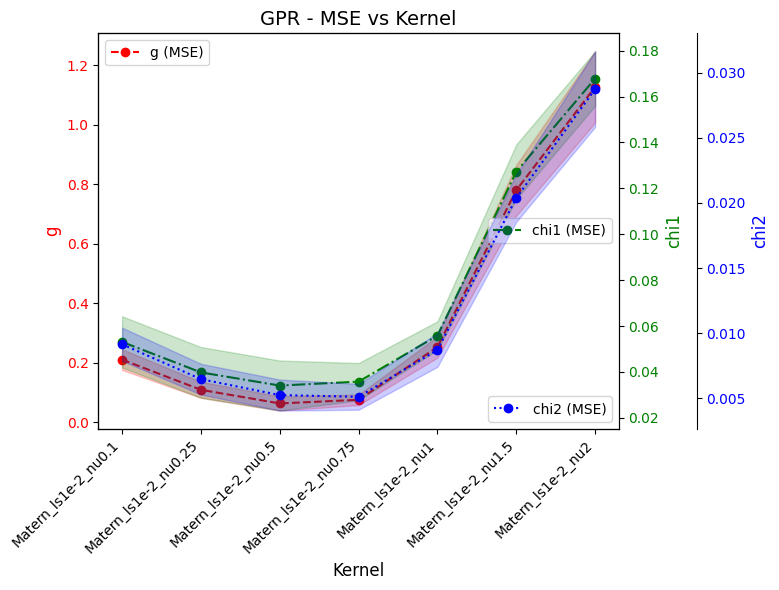

In [22]:
matern_kernels = {
    # winner is ls1e-2 nu0.5
    'Matern_ls1e-2_nu0.1': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=0.1),
    'Matern_ls1e-2_nu0.25': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=0.25),
    'Matern_ls1e-2_nu0.5': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=0.5),
    'Matern_ls1e-2_nu0.75': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=0.75),
    'Matern_ls1e-2_nu1': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=1),
    'Matern_ls1e-2_nu1.5': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=1.5),
    'Matern_ls1e-2_nu2': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=2),
}
matern_metrics = run_kernels(matern_kernels)
plot_kernel_performance(matern_metrics, confidence_interval=True)
get_performance_table(matern_metrics)
# conclusion: nu=0.5 is the best

Running kernel: Matern_ls1e-2_nu0.25


100%|██████████| 5/5 [01:32<00:00, 18.42s/it]


Running kernel: Matern_ls1e-1_nu0.25


100%|██████████| 5/5 [01:22<00:00, 16.59s/it]


Running kernel: Matern_ls1e-0_nu0.25


100%|██████████| 5/5 [01:13<00:00, 14.65s/it]


Running kernel: Matern_ls1e1_nu0.25


100%|██████████| 5/5 [01:04<00:00, 12.88s/it]


Running kernel: Matern_ls1e2_nu0.25


100%|██████████| 5/5 [01:11<00:00, 14.24s/it]
/tmp/ipykernel_79435/2111778922.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right')


,Kernel,g (MSE),chi1 (MSE),chi2 (MSE)
0,Matern_ls1e-2_nu0.25,0.109 ± 0.027,0.040 ± 0.011,0.006 ± 0.001
1,Matern_ls1e-1_nu0.25,0.109 ± 0.027,0.040 ± 0.011,0.006 ± 0.001
2,Matern_ls1e-0_nu0.25,0.109 ± 0.027,0.040 ± 0.011,0.006 ± 0.001
3,Matern_ls1e1_nu0.25,0.109 ± 0.027,0.040 ± 0.011,0.006 ± 0.001
4,Matern_ls1e2_nu0.25,0.109 ± 0.027,0.040 ± 0.011,0.006 ± 0.001


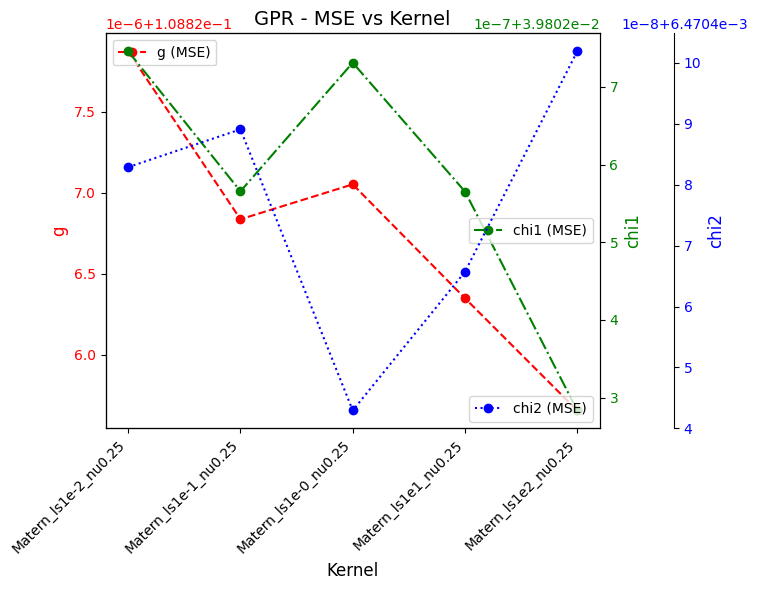

In [23]:
matern_kernels = {
    'Matern_ls1e-2_nu0.25': 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=0.25),
    'Matern_ls1e-1_nu0.25': 1 * Matern(length_scale=1e-1, length_scale_bounds=(1e-3, 1e3), nu=0.25),
    'Matern_ls1e-0_nu0.25': 1 * Matern(length_scale=1e0, length_scale_bounds=(1e-3, 1e3), nu=0.25),
    'Matern_ls1e1_nu0.25': 1 * Matern(length_scale=1e1, length_scale_bounds=(1e-3, 1e3), nu=0.25),
    'Matern_ls1e2_nu0.25': 1 * Matern(length_scale=1e2, length_scale_bounds=(1e-3, 1e3), nu=0.25),
}
matern_metrics = run_kernels(matern_kernels)
plot_kernel_performance(matern_metrics, confidence_interval=False)
get_performance_table(matern_metrics)
# conclusion: length scale doesn't make a difference

Running kernel: White_1e-2


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


Running kernel: White_1e-1


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Running kernel: White_1e0


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Running kernel: White_1e1


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Running kernel: White_1e2


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
/tmp/ipykernel_79435/2111778922.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right')


,Kernel,g (MSE),chi1 (MSE),chi2 (MSE)
0,White_1e-2,3.970 ± 0.254,0.321 ± 0.025,0.086 ± 0.002
1,White_1e-1,3.970 ± 0.254,0.321 ± 0.025,0.086 ± 0.002
2,White_1e0,3.970 ± 0.254,0.321 ± 0.025,0.086 ± 0.002
3,White_1e1,3.970 ± 0.254,0.321 ± 0.025,0.086 ± 0.002
4,White_1e2,3.970 ± 0.254,0.321 ± 0.025,0.086 ± 0.002


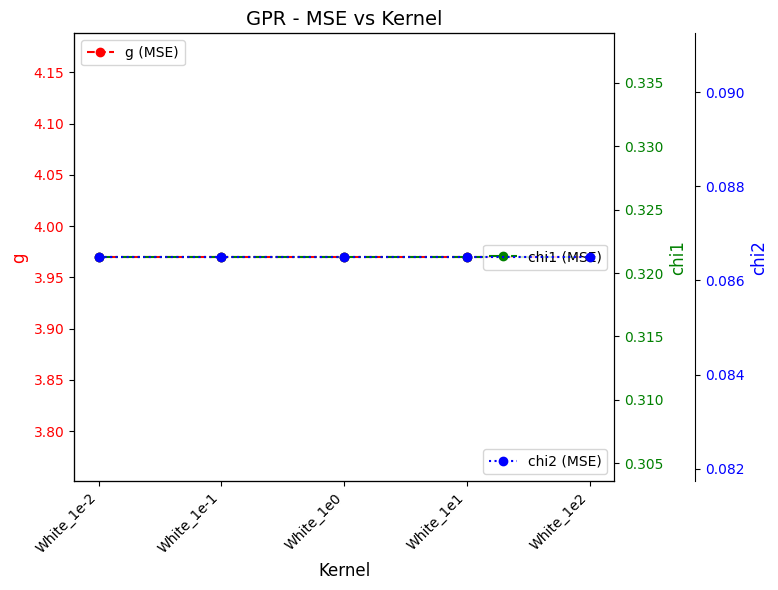

In [24]:
white_kernels = {
    'White_1e-2': 1 * WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e5)),
    'White_1e-1': 1 * WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-5, 1e5)),
    'White_1e0': 1 * WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-5, 1e5)),
    'White_1e1': 1 * WhiteKernel(noise_level=1e1, noise_level_bounds=(1e-5, 1e5)),
    'White_1e2': 1 * WhiteKernel(noise_level=1e2, noise_level_bounds=(1e-5, 1e5)),
}
white_metrics = run_kernels(white_kernels)
plot_kernel_performance(white_metrics, confidence_interval=False)
get_performance_table(white_metrics)
# conclusion: noise level doesn't make a difference

Running kernel: Constant_1e-4


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Running kernel: Constant_1e-3


  0%|          | 0/5 [00:00<?, ?it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Running kernel: Constant_1e-2


 20%|██        | 1/5 [00:01<00:04,  1.10s/it]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Running kernel: Constant_1e-1


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Running kernel: Constant_1e0


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Running kernel: Constant_1e1


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Running kernel: Constant_1e2


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


Running kernel: Constant_1e3


  0%|          | 0/5 [00:00<?, ?it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
 20%|██        | 1/5 [00:00<00:01,  2.78it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
 40%|████      | 2/5 [00:00<00:01,  2.66it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
 60%|██████    | 3/5 [00:01<00:00,  2.65it/s]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

Running kernel: Constant_1e4


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 40%|████      | 2/5 [00:06<00:10,  3.66s/it]/home/stevie/repos/microstructure_analysis/venv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|██████████| 5/5 [00:16<00:00,  3.32s/it]
/tmp/ipykernel_79435/2111778922.py:8: UserWarning: FixedFormatter should only be used togeth

,Kernel,g (MSE),chi1 (MSE),chi2 (MSE)
0,Constant_1e-4,3.980 ± 0.254,0.323 ± 0.026,0.087 ± 0.003
1,Constant_1e-3,3.980 ± 0.254,0.323 ± 0.026,0.087 ± 0.003
2,Constant_1e-2,3.980 ± 0.254,0.323 ± 0.026,0.087 ± 0.003
3,Constant_1e-1,3.980 ± 0.254,0.323 ± 0.026,0.087 ± 0.003
4,Constant_1e0,3.980 ± 0.254,0.323 ± 0.026,0.087 ± 0.003
5,Constant_1e1,3.981 ± 0.255,0.323 ± 0.026,0.087 ± 0.003
6,Constant_1e2,4.010 ± 0.234,0.326 ± 0.025,0.087 ± 0.003
7,Constant_1e3,4.105 ± 0.222,0.338 ± 0.018,0.088 ± 0.002
8,Constant_1e4,3.980 ± 0.254,0.323 ± 0.026,0.087 ± 0.003


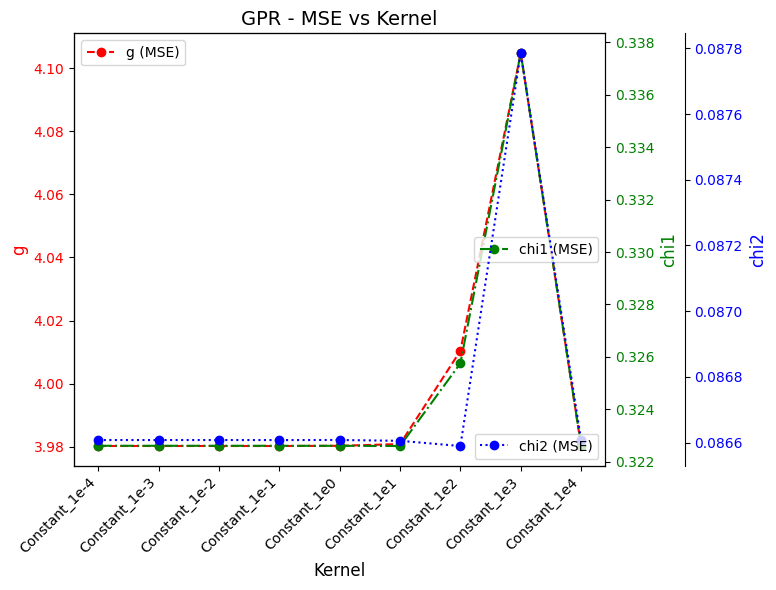

In [25]:
constant_kernels = {
    'Constant_1e-4': 1 * ConstantKernel(constant_value=1e-4, constant_value_bounds=(1e-5, 1e5)),
    'Constant_1e-3': 1 * ConstantKernel(constant_value=1e-3, constant_value_bounds=(1e-5, 1e5)),
    'Constant_1e-2': 1 * ConstantKernel(constant_value=1e-2, constant_value_bounds=(1e-5, 1e5)),
    'Constant_1e-1': 1 * ConstantKernel(constant_value=1e-1, constant_value_bounds=(1e-5, 1e5)),
    'Constant_1e0': 1 * ConstantKernel(constant_value=1e0, constant_value_bounds=(1e-5, 1e5)),
    'Constant_1e1': 1 * ConstantKernel(constant_value=1e1, constant_value_bounds=(1e-5, 1e5)),
    'Constant_1e2': 1 * ConstantKernel(constant_value=1e2, constant_value_bounds=(1e-5, 1e5)),
    'Constant_1e3': 1 * ConstantKernel(constant_value=1e3, constant_value_bounds=(1e-5, 1e5)),
    'Constant_1e4': 1 * ConstantKernel(constant_value=1e4, constant_value_bounds=(1e-5, 1e5)),
}
constant_metrics = run_kernels(constant_kernels)
plot_kernel_performance(constant_metrics, confidence_interval=False)
get_performance_table(constant_metrics)
# conclusion: constant kernels are suboptimal

Running kernel: RationalQuadratic_1e-2


100%|██████████| 5/5 [00:24<00:00,  4.96s/it]


Running kernel: RationalQuadratic_1e-1


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


Running kernel: RationalQuadratic_1e0


100%|██████████| 5/5 [00:33<00:00,  6.64s/it]


Running kernel: RationalQuadratic_1e1


100%|██████████| 5/5 [00:46<00:00,  9.39s/it]


Running kernel: RationalQuadratic_1e2


100%|██████████| 5/5 [00:44<00:00,  8.96s/it]
/tmp/ipykernel_79435/2111778922.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right')


,Kernel,g (MSE),chi1 (MSE),chi2 (MSE)
0,RationalQuadratic_1e-2,0.181 ± 0.029,0.048 ± 0.010,0.008 ± 0.001
1,RationalQuadratic_1e-1,0.181 ± 0.029,0.048 ± 0.010,0.008 ± 0.001
2,RationalQuadratic_1e0,0.181 ± 0.029,0.048 ± 0.010,0.008 ± 0.001
3,RationalQuadratic_1e1,0.181 ± 0.029,0.048 ± 0.010,0.008 ± 0.001
4,RationalQuadratic_1e2,0.181 ± 0.029,0.048 ± 0.010,0.008 ± 0.001


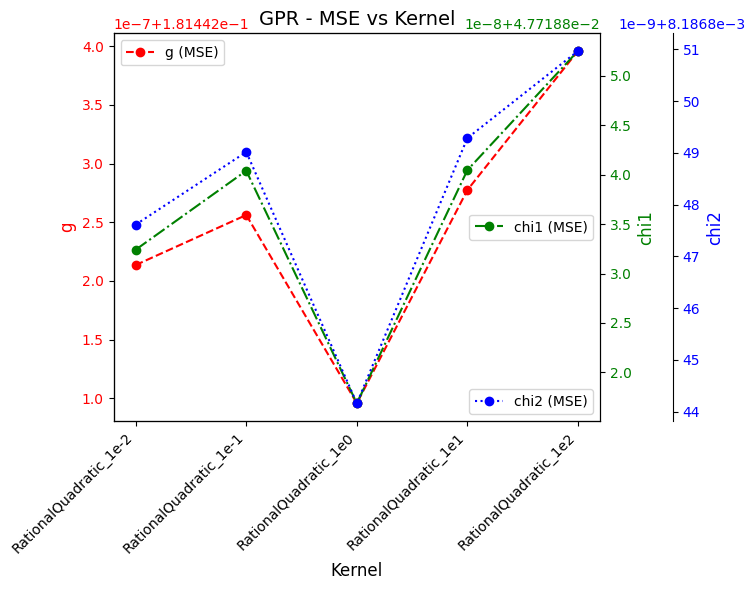

In [26]:
rational_quadratic_kernels = {
    'RationalQuadratic_1e-2': 1 * RationalQuadratic(length_scale=1e-2, length_scale_bounds=(1e-2, 1e2)),
    'RationalQuadratic_1e-1': 1 * RationalQuadratic(length_scale=1e-1, length_scale_bounds=(1e-2, 1e2)),
    'RationalQuadratic_1e0': 1 * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    'RationalQuadratic_1e1': 1 * RationalQuadratic(length_scale=1e1, length_scale_bounds=(1e-2, 1e2)),
    'RationalQuadratic_1e2': 1 * RationalQuadratic(length_scale=1e2, length_scale_bounds=(1e-2, 1e2)),
}
rational_quadratic_metrics = run_kernels(rational_quadratic_kernels)
plot_kernel_performance(rational_quadratic_metrics, confidence_interval=False)
get_performance_table(rational_quadratic_metrics)
# conclusion: length scale doesn't make a difference

Running kernel: RationalQuadratic_1e0_a0.01


100%|██████████| 5/5 [00:23<00:00,  4.60s/it]


Running kernel: RationalQuadratic_1e0_a0.1


100%|██████████| 5/5 [00:27<00:00,  5.43s/it]


Running kernel: RationalQuadratic_1e0_a1


100%|██████████| 5/5 [00:38<00:00,  7.79s/it]


Running kernel: RationalQuadratic_1e0_a10


100%|██████████| 5/5 [00:37<00:00,  7.55s/it]


Running kernel: RationalQuadratic_1e0_a100


100%|██████████| 5/5 [00:41<00:00,  8.28s/it]
/tmp/ipykernel_79435/2111778922.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right')


,Kernel,g (MSE),chi1 (MSE),chi2 (MSE)
0,RationalQuadratic_1e0_a0.01,0.181 ± 0.029,0.048 ± 0.010,0.008 ± 0.001
1,RationalQuadratic_1e0_a0.1,0.181 ± 0.029,0.048 ± 0.010,0.008 ± 0.001
2,RationalQuadratic_1e0_a1,0.181 ± 0.029,0.048 ± 0.010,0.008 ± 0.001
3,RationalQuadratic_1e0_a10,0.197 ± 0.033,0.051 ± 0.009,0.009 ± 0.001
4,RationalQuadratic_1e0_a100,0.206 ± 0.064,0.051 ± 0.016,0.009 ± 0.002


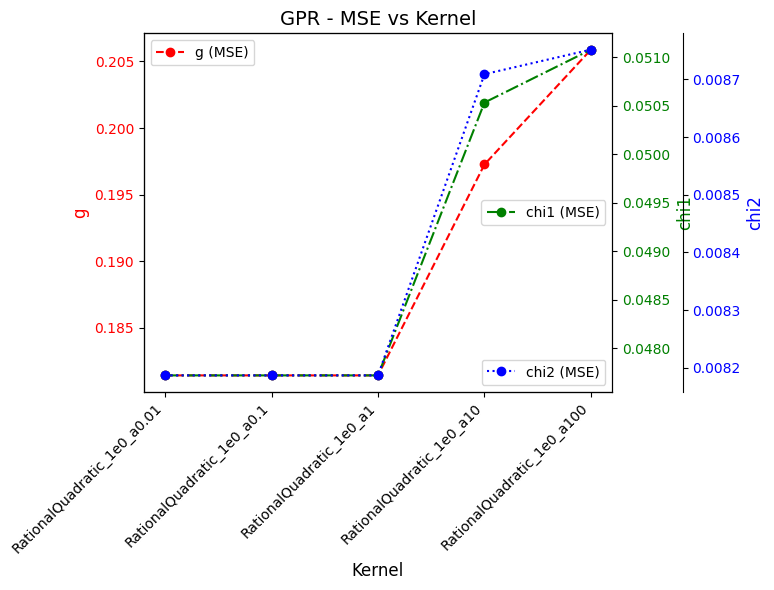

In [27]:
rational_quadratic_kernels = {
    'RationalQuadratic_1e0_a0.01': 1 * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), alpha=0.01, alpha_bounds=(1e-5, 1e5)),
    'RationalQuadratic_1e0_a0.1': 1 * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), alpha=0.1, alpha_bounds=(1e-5, 1e5)),
    'RationalQuadratic_1e0_a1': 1 * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), alpha=1.0, alpha_bounds=(1e-5, 1e5)),
    'RationalQuadratic_1e0_a10': 1 * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), alpha=10.0, alpha_bounds=(1e-5, 1e5)),
    'RationalQuadratic_1e0_a100': 1 * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), alpha=100.0, alpha_bounds=(1e-5, 1e5)),
}
rational_quadratic_metrics = run_kernels(rational_quadratic_kernels)
plot_kernel_performance(rational_quadratic_metrics, confidence_interval=False)
get_performance_table(rational_quadratic_metrics)
# conclusion: alpha has no effect

# Hyperparmeter Selection

After performing grid search on several kernels and other hyperparameters, I found that the following Mattern kernel performed best during K-Fold cross validation.

In [28]:
best_kernel = 1 * Matern(length_scale=1e-2, length_scale_bounds=(1e-3, 1e3), nu=0.5)

# Training Error

## Training Error (without using validation set)

This approach is problematic for a couple reasons. 

First, our model has "seen" the training data we are testing
with. This means that it is going to perform much much better than unseen data. So these results don't tell us
much. 

Second, we only get one MSE and MAE statistic this way. If we use K-Fold cross validation instead, we will 
get a mean and std of the MSE and MAE, giving us a more accurate results as well as a sense of the variance between
runs.

In [29]:
gaussian_process = GaussianProcessRegressor(kernel=best_kernel, alpha=1e-10, n_restarts_optimizer=0)
gaussian_process.fit(X_train_scaled, y_train_scaled)

train_mean_pred_scaled, train_std_pred_scaled = gaussian_process.predict(
    X_train_scaled, return_std=True)

train_mean_pred = y_scaler.inverse_transform(train_mean_pred_scaled)
train_std_pred = y_scaler.inverse_transform(train_std_pred_scaled)

y_train_star = train_df[['g', 'chi1', 'chi2']].values
y_train = y_scaler.inverse_transform(y_train_scaled)
# sanity check: y_train_star == y_train
assert(np.allclose(y_train_star, y_train))
mse = np.mean((train_mean_pred - y_train)**2, axis=0)
mae = np.mean(np.abs(train_mean_pred - y_train), axis=0)

data = {'Variable': [], 'MSE': [], 'MAE': []}
for i, key in enumerate(['g', 'chi1', 'chi2']):
    data['Variable'].append(key)
    # eponential notation
    data['MSE'].append(f"{mse[i]:.4e}")
    data['MAE'].append(f"{mae[i]:.4e}")
pd.DataFrame(data)

,Variable,MSE,MAE
0,g,2.8031e-19,2.2570e-10
1,chi1,1.1752e-18,2.9503e-10
2,chi2,2.0264e-20,7.2106e-11


## Training Error (using K-Fold cross validation)

In [30]:
mse_list = []
mae_list = []
pred_vec = None
true_vec = None

kf = KFold(n_splits=K)
for train_index, val_index in tqdm(kf.split(X_train_scaled), total=K):
    kf_X_train_scaled = X_train_scaled[train_index]
    kf_X_val_scaled = X_train_scaled[val_index]
    kf_y_train_scaled = y_train_scaled[train_index]
    kf_y_val_scaled = y_train_scaled[val_index]

    gaussian_process = GaussianProcessRegressor(kernel=best_kernel, alpha=1e-10, n_restarts_optimizer=0)
    gaussian_process.fit(kf_X_train_scaled, kf_y_train_scaled)

    val_mean_pred_scaled, val_std_pred_scaled = gaussian_process.predict(
        kf_X_val_scaled, return_std=True)
    
    val_mean_pred = y_scaler.inverse_transform(val_mean_pred_scaled)
    val_std_pred = y_scaler.inverse_transform(val_std_pred_scaled)

    kf_y_val_star = train_df[['g', 'chi1', 'chi2']].values[val_index]
    kf_y_val = y_scaler.inverse_transform(kf_y_val_scaled)
    # sanity check: kf_y_val_star == kf_y_val
    assert(np.allclose(kf_y_val_star, kf_y_val))

    if pred_vec is None:
        pred_vec = val_mean_pred
        true_vec = kf_y_val
    else:
        pred_vec = np.concatenate([pred_vec, val_mean_pred], axis=0)
        true_vec = np.concatenate([true_vec, kf_y_val], axis=0)

    mse = np.mean((val_mean_pred - kf_y_val)**2, axis=0)
    mae = np.mean(np.abs(val_mean_pred - kf_y_val), axis=0)
    mse_list.append(mse)
    mae_list.append(mae)

mse_mean = np.mean(mse_list, axis=0)
mse_std = np.std(mse_list, axis=0)
mae_mean = np.mean(mae_list, axis=0)
mae_std = np.std(mae_list, axis=0)
data = {'Variable': [], 'Mean MSE': [], 'Std MSE': [], 'Mean MAE': [], 'Std MAE': []}
for i, key in enumerate(['g', 'chi1', 'chi2']):
    data['Variable'].append(key)
    data['Mean MSE'].append(f"{mse_mean[i]:.4f}")
    data['Std MSE'].append(f"{mse_std[i]:.4f}")
    data['Mean MAE'].append(f"{mae_mean[i]:.4f}")
    data['Std MAE'].append(f"{mae_std[i]:.4f}")
pd.DataFrame(data)

100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


,Variable,Mean MSE,Std MSE,Mean MAE,Std MAE
0,g,0.0630,0.0240,0.1470,0.0201
1,chi1,0.0341,0.0109,0.1161,0.0135
2,chi2,0.0052,0.0012,0.0461,0.0056


# Parity Plots

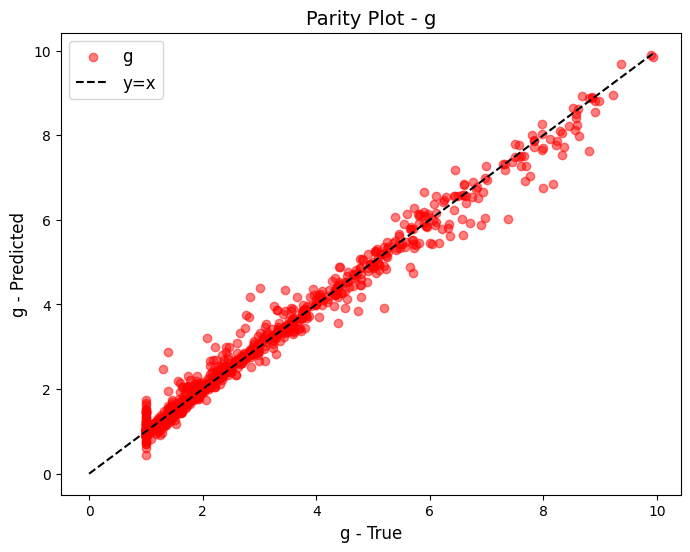

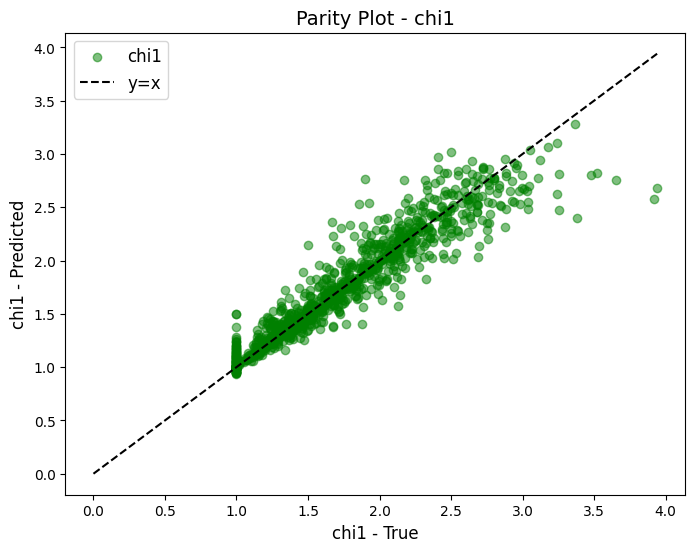

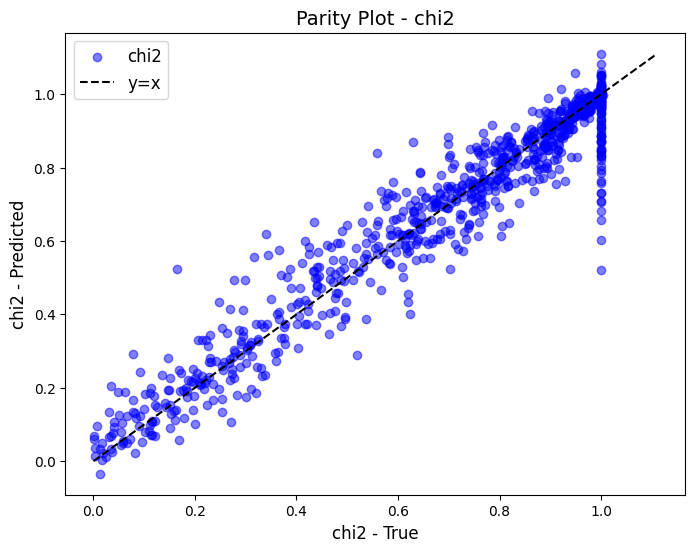

In [31]:
### parity plots
def plot_parity(true, pred, key, color):
    max_x = max(true.max(), pred.max())
    plt.figure(figsize=(8, 6))
    plt.scatter(true, pred, c=color, marker='o', label=key, alpha=0.5)
    plt.plot([0, max_x], [0, max_x], c='black', linestyle='--', label='y=x')
    plt.title(f'Parity Plot - {key}', fontsize=FONTSIZE)
    plt.xlabel(f'{key} - True', fontsize=FONTSIZE-2)
    plt.ylabel(f'{key} - Predicted', fontsize=FONTSIZE-2)
    plt.legend(fontsize=FONTSIZE-2)

plot_parity(true_vec[:, 0], pred_vec[:, 0], 'g', 'r')
plot_parity(true_vec[:, 1], pred_vec[:, 1], 'chi1', 'g')
plot_parity(true_vec[:, 2], pred_vec[:, 2], 'chi2', 'b')

# Transform Testing Data

In [32]:
gaussian_process = GaussianProcessRegressor(kernel=best_kernel, alpha=1e-10, n_restarts_optimizer=0)
gaussian_process.fit(X_train_scaled, y_train_scaled)

test_mean_pred_scaled, test_std_pred_scaled = gaussian_process.predict(
    X_test_scaled, return_std=True)

test_mean_pred = y_scaler.inverse_transform(test_mean_pred_scaled)
test_std_pred = y_scaler.inverse_transform(test_std_pred_scaled)

for i, key in enumerate(['g', 'chi1', 'chi2']):
    test_df[f'{key}_pred'] = test_mean_pred[:, i]
    test_df[f'{key}_std'] = test_std_pred[:, i]
    test_df[f'{key}_-2std'] = test_df[f'{key}_pred'] - 2 * test_df[f'{key}_std']
    test_df[f'{key}_+2std'] = test_df[f'{key}_pred'] + 2 * test_df[f'{key}_std']

In [33]:
test_df.head(10)

,microstructure ID,strength contrast,g_pred,g_std,g_-2std,g_+2std,chi1_pred,chi1_std,chi1_-2std,chi1_+2std,chi2_pred,chi2_std,chi2_-2std,chi2_+2std
0,778,6,2.816782,3.565936,-4.315090,9.948654,1.941628,1.951713,-1.961799,5.845055,0.716735,0.828118,-0.939502,2.372972
1,4,10,4.217161,3.608162,-2.999163,11.433484,2.907380,1.963726,-1.020072,6.834831,0.637436,0.834351,-1.031267,2.306138
2,721,9,1.178653,3.472600,-5.766548,8.123853,1.449525,1.925162,-2.400798,5.299849,0.189098,0.814341,-1.439584,1.817780
3,194,1,1.032638,3.523893,-6.015148,8.080424,1.292666,1.939753,-2.586841,5.172172,0.772549,0.821912,-0.871276,2.416374
4,536,3,1.835659,3.323021,-4.810384,8.481702,1.591708,1.882610,-2.173513,5.356929,0.846612,0.792262,-0.737912,2.431136
5,356,5,2.200406,3.195101,-4.189796,8.590607,1.648937,1.846220,-2.043504,5.341377,0.746707,0.773380,-0.800052,2.293467
6,747,10,1.813067,3.526737,-5.240406,8.866541,1.984027,1.940562,-1.897097,5.865152,0.214436,0.822332,-1.430229,1.859100
7,277,7,3.805007,3.546983,-3.288959,10.898973,2.142477,1.946322,-1.750167,6.035120,0.840692,0.825321,-0.809949,2.491334
8,722,9,3.048133,3.965385,-4.882637,10.978903,2.062021,2.065347,-2.068673,6.192714,0.638493,0.887080,-1.135668,2.412654
9,496,1,1.002003,3.377616,-5.753229,7.757236,0.992697,1.898141,-2.803585,4.788980,1.014050,0.800321,-0.586591,2.614692


In [34]:
test_df.to_csv('dataset/testing_data_pred.csv', index=False)